<a href="https://colab.research.google.com/github/bhaveshUp2010/satterlite_image_segmentation/blob/main/Satterlite_image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install patchify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 71.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatib

##Installing the dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bupadhyay2006","key":"90f821779462bccf24eb21d72d6bf84f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
  0% 0.00/29.6M [00:00<?, ?B/s]
100% 29.6M/29.6M [00:00<00:00, 890MB/s]


In [ ]:
!unzip semantic-segmentation-of-aerial-imagery.zip -d ./aerial_dataset

Archive:  semantic-segmentation-of-aerial-imagery.zip
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg  
  inflating: ./aerial_dataset/Semantic segmentation dataset/Tile 1/masks/image_part_001.png

##Doing Necessary Imports

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from patchify import patchify
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import random

In [ ]:
min_max_scaler = MinMaxScaler()

##Mounted dataset to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
drive_path = '/content/drive/MyDrive/aerial_dataset'
os.makedirs(drive_path, exist_ok= True)

In [ ]:
!cp -r ./aerial_dataset/* "/content/drive/MyDrive/aerial_dataset/"

In [ ]:
ds_root_folder = "/content/drive/MyDrive/aerial_dataset/"
ds_name = "Semantic segmentation dataset"

##Processing the images

In [ ]:
for path, subdirs, files in os.walk(os.path.join(ds_root_folder, ds_name)):
  dir_name = path.split(os.path.sep)[-1]
  #print(dir_name)
  if dir_name == 'masks': # 'images
    images = os.listdir(path)
    print(path)
    #print(images)
    for i, image_name in enumerate(images):
      if (image_name.endswith('.png')): # '.jpg
        # print(image_name)
        a =True

/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 1/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 2/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 3/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 4/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 5/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 6/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 7/masks
/content/drive/MyDrive/aerial_dataset/Semantic segmentation dataset/Tile 8/masks


In [ ]:
image_ds = []
mask_ds = []
image_patch_size = 256
for image_type in ["images", "masks"]:
    if image_type == "images":
      image_extension = "jpg"
    elif image_type == "masks":
      image_extension = "png"
    for tile_id in range(1, 8):
      for image_id in range(1, 20):
        image = cv2.imread(f'{ds_root_folder}/{ds_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}', 1)
        if image is not None:
          if image_type == "masks":
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          # print(image.shape)
          size_x = (image.shape[1]//image_patch_size)*image_patch_size
          size_y = (image.shape[0]//image_patch_size)*image_patch_size
          image = Image.fromarray(image)
          image = image.crop((0, 0, size_x, size_y))
          image = np.array(image)
          patchified_image = patchify(image, (image_patch_size, image_patch_size, 3), step= image_patch_size)
          # print(patchified_image.shape)
          # print(len(patchified_image))
          for i in range(patchified_image.shape[0]):
            for j in range(patchified_image.shape[1]):
              if image_type == "images":
                individual_patched_img = patchified_image[i,j,:,:]
                # print(individual_patched_img.shape)
                individual_patched_img = min_max_scaler.fit_transform(individual_patched_img.reshape(-1, individual_patched_img.shape[-1])).reshape(individual_patched_img.shape)
                individual_patched_img = individual_patched_img[0]
                #print(individual_patched_img.shape)
                image_ds.append(individual_patched_img)
              elif image_type == "masks":
                individual_patched_mask = patchified_image[i,j,:,:]
                individual_patched_mask = individual_patched_mask[0]
                #print(individual_patched_mask.shape)
                mask_ds.append(individual_patched_mask)

In [ ]:
print(len(image_ds))
print(len(mask_ds))
print(type(image_ds))
print(type(mask_ds))

945
945
<class 'list'>
<class 'list'>


In [ ]:
image_ds = np.array(image_ds)
mask_ds = np.array(mask_ds)
print(len(image_ds))
print(len(mask_ds))
print(type(image_ds))
print(type(mask_ds))

945
945
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


##Plot Random Images

(-0.5, 255.5, 255.5, -0.5)

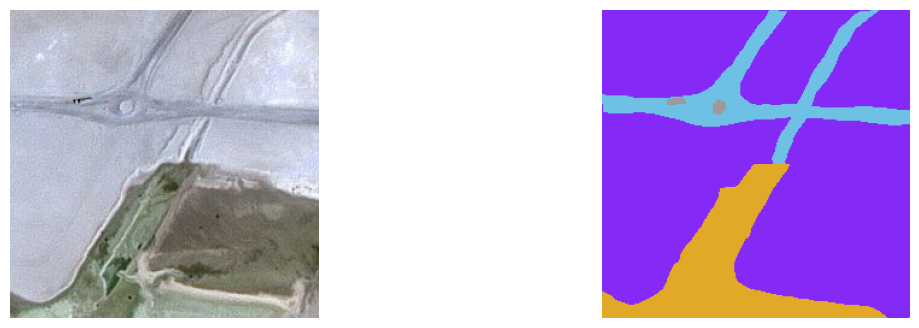

In [ ]:
random_image_id = random.randint(0, len(image_ds))
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.imshow(image_ds[random_image_id])
plt.axis("off")
plt.subplot(122)
plt.imshow(mask_ds[random_image_id])
plt.axis("off")

##Converting hex to RGB

In [ ]:
Building_class = "#3C1098"
Building_class = Building_class.lstrip("#")
Building_class = np.array(tuple(int(Building_class[i:i+2], 16) for i in (0,2,4)))
print(Building_class)

Land_class = "#8429F6"
Land_class = Land_class.lstrip("#")
Land_class = np.array(tuple(int(Land_class[i:i+2], 16) for i in (0,2,4)))
print(Land_class)

Road_class = "#6EC1E4"
Road_class = Road_class.lstrip("#")
Road_class = np.array(tuple(int(Road_class[i:i+2], 16) for i in (0,2,4)))
print(Road_class)

Vegetation_class = "#FEDD3A"
Vegetation_class = Vegetation_class.lstrip("#")
Vegetation_class = np.array(tuple(int(Vegetation_class[i:i+2], 16) for i in (0,2,4)))
print(Vegetation_class)

Water_class = "#E2A929"
Water_class = Water_class.lstrip("#")
Water_class = np.array(tuple(int(Water_class[i:i+2], 16) for i in (0,2,4)))
print(Water_class)

Unlabeled_class = "#9B9B9B"
Unlabeled_class = Unlabeled_class.lstrip("#")
Unlabeled_class = np.array(tuple(int(Unlabeled_class[i:i+2], 16) for i in (0,2,4)))
print(Unlabeled_class)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


##Labelling mask images

In [ ]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype = np.uint8)
  label_segment[np.all(label == Water_class, axis=-1)] = 0
  label_segment[np.all(label == Land_class, axis=-1)] = 1
  label_segment[np.all(label == Road_class, axis=-1)] = 2
  label_segment[np.all(label == Building_class, axis=-1)] = 3
  label_segment[np.all(label == Vegetation_class, axis=-1)] = 4
  label_segment[np.all(label == Unlabeled_class, axis=-1)] = 5

  label_segment = label_segment[:,:,0]
  return label_segment

In [ ]:
labels = []
for i in range(mask_ds.shape[0]):
  label = rgb_to_label(mask_ds[i])
  labels.append(label)

In [ ]:
labels = np.array(labels)

In [ ]:
labels.shape

(945, 256, 256)

In [ ]:
labels = np.expand_dims(labels, axis=3)

In [ ]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


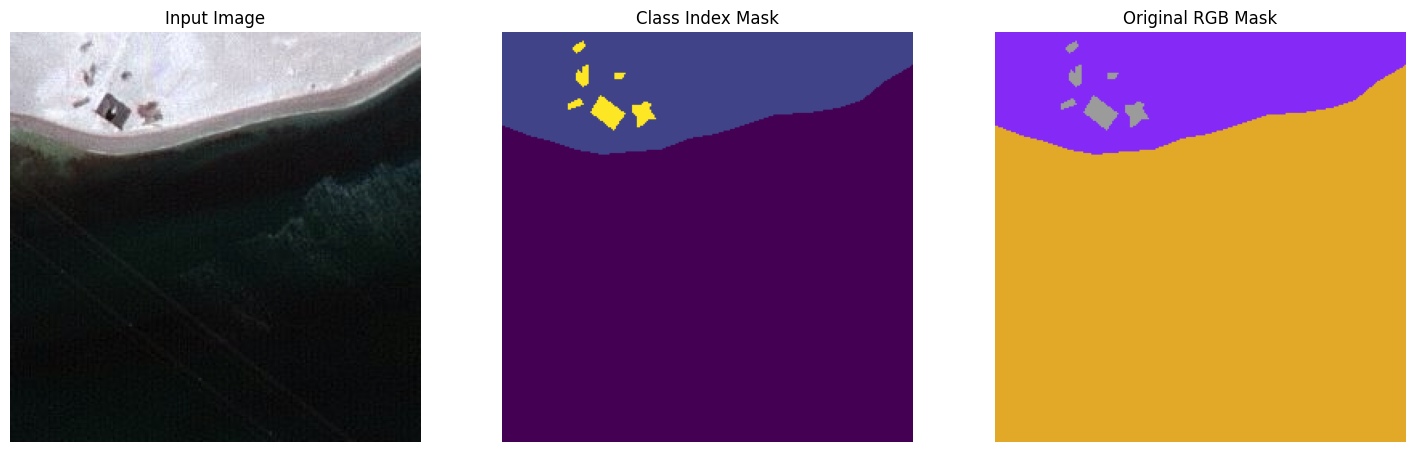

In [ ]:
random_image_id = random.randint(0, len(image_ds))
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_ds[random_image_id])
plt.title("Input Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(labels[random_image_id][:,:,0])  # Use colormap for class indices
plt.title("Class Index Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask_ds[random_image_id])
plt.title("Original RGB Mask")
plt.axis("off")

plt.show()

##Creating train test set

In [ ]:
total_classes = len(np.unique(labels))

In [ ]:
labels_categorical_ds = to_categorical(labels, num_classes=total_classes)

In [ ]:
labels_categorical_ds.shape

(945, 256, 256, 6)

In [ ]:
master_training_ds = image_ds

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(master_training_ds, labels_categorical_ds, test_size=0.15, random_state=100)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)
